### Comparing the hard random SK instances with the transformed instance 

In [1]:
using QAOA
using DifferentialEquations
using SpinFluctuations
using Arpack    
using PyPlot 
using HDF5 
using Printf
using LinearAlgebra, Random, Distributions
using Dates, Crayons
using Revise
using SparseArrays
using Parameters
using Interpolations
using DataFrames

In [2]:
# load the SK hard instance data

# number of spins
N = 12

PATH = raw"/home/ubuntu/aqc_QAOA/transformation_hard_SK_instances"
subdir = "small_gaps"
folder_name = PATH * @sprintf("//data//N_%i//", N);

PATH_o = raw"/home/ubuntu/aqc_QAOA/SpinFluctuations.jl"
folder_name_o = PATH_o * @sprintf("//data//N_%i//", N);


seed = 19

# 125859 not found the 0.5 s_gap

# Transformed instance

#file_name = folder_name * @sprintf("rev_transf_hard_random_SK_instance_N_%i_seed_%i.h5", N , seed)
file_name = folder_name * @sprintf("transformed_hard_SK_instance_N_%i_seed_%i.h5", N , seed)


gs_energy = h5read(file_name, "ground_state_energy") 
J_mat = h5read(file_name, "couplings"); 
local_fields = h5read(file_name, "local_fields")
time_step = h5read(file_name, "time_step") 
#adiabatic_peak = h5read(file_name, "adiabatic_peak")
mf_problem = Problem(0, local_fields, J_mat);

println(gs_energy)
println(J_mat)
println(time_step)

# Original instance

file_name_o = folder_name_o * @sprintf("hard_random_SK_instance_N_%i_seed_%i.h5", N , seed)

gs_energy_o = h5read(file_name_o, "ground_state_energy") 
J_mat_o = h5read(file_name_o, "couplings"); 
local_fields_o = h5read(file_name_o, "local_fields")
#adiabatic_peak_o = h5read(file_name_o, "adiabatic_peak")
mf_problem_o = Problem(0, local_fields_o, J_mat_o);

println(gs_energy_o)
println(J_mat_o)

-23.88094381785203
[0.0 0.7424832100393485 0.5731275372184316 0.9519869064236782 0.45173740645799365 -0.3028380305500772 1.328221063162527 0.6517702404527509 -0.6377929035998857 0.2695618965682629 0.5860604692915168 -0.5534619303608193; 0.7424832100393485 0.0 0.042621284994424545 -0.0512878411686244 0.4661712669168564 -0.6426022955213943 -1.2300649680615103 1.1709224245147531 -0.7470375929415913 0.6192931741257447 0.633736849097085 1.4816992646664622; 0.5731275372184316 0.042621284994424545 0.0 0.43760463762446017 0.22433381453260148 0.9932236786121285 -0.5669482296013613 -0.4389968400876327 -0.3642021177187062 1.6199420118781571 -0.6772104614296531 -0.219263556826458; 0.9519869064236782 -0.0512878411686244 0.43760463762446017 0.0 0.7933226284799741 -1.06434414493618 -0.46982628831474355 0.2761241064493468 1.811844310211323 -1.217535528978777 0.039669014839674645 0.4367137888833555; 0.45173740645799365 0.4661712669168564 0.22433381453260148 0.7933226284799741 0.0 -0.9179255403070244 0.

#### Calculate the exact spectrum of the original instances

In [63]:
nev = 100
keep_EVs = 10
#time_step = 39

exact_times = range(0, 1, time_step)
eigeninfo = map(s -> (eigs(-hamiltonian(1 - s, s, mf_problem_o.local_fields, mf_problem_o.couplings), nev=nev, which=:LM, maxiter=10000)), exact_times)
lambda_s = [vals[1] for vals in eigeninfo]
lambda = sort(reduce(hcat, lambda_s), dims=1)


#all_eigvecs = zeros(length(exact_times), 2^(N-1), keep_EVs)
all_eigvecs = zeros(length(exact_times), 2^(N), keep_EVs)
for k in 1:length(exact_times)
    sorting_perm = sortperm(lambda_s[k])
    all_eigvecs[k, :, :] .= eigeninfo[k][2][:, sorting_perm[1:keep_EVs]]
end

# without fixing a spin
#all_eigvecs = zeros(length(exact_times), 2^(N-1), keep_EVs)
all_eigvecs = zeros(length(exact_times), 2^(N), keep_EVs)
for k in 1:length(exact_times)
    sorting_perm = sortperm(lambda_s[k])
    all_eigvecs[k, :, :] .= eigeninfo[k][2][:, sorting_perm[1:keep_EVs]]
end

println(lambda[1, :])

[-11.999999999999988, -11.601201902949164, -11.20497000429297, -10.811574071692462, -10.42132401630264, -10.034577751799931, -9.651751054112534, -9.27333011086345, -8.899887782525152, -8.532105147447998, -8.170800844151552, -7.816972387850952, -7.471856662617375, -7.137022400813526, -6.814517891059146, -6.507115652665745, -6.218721659922454, -5.955007063821615, -5.7239921390329656, -5.5347932331182115, -5.391849182157323, -5.291255064461383, -5.226626189663186, -5.193551754243178, -5.201287223680878, -5.263286122775033, -5.353826418732348, -5.471443573594813, -5.614583875614722, -5.781488631988967, -5.970235954463013]


In [64]:
# calculate adiabatic ratio

H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem_o.local_fields, mf_problem_o.couplings)
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem_o.local_fields, mf_problem_o.couplings);

gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)]

overlap_01_x = [first_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_01_z = [first_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)]

overlap_02_x = [second_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_02_z = [second_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

#println(abs.(overlap_01_z .- overlap_01_x))

gap = lambda[2, :] .- lambda[1, :];
mingap = minimum(gap)
#mingap |> println
gap_idx = findfirst(x -> x == mingap, gap)
s_gap = exact_times[gap_idx]
println("s_* for Gamma = 1:")

println(gap .* gap)
println(abs.(overlap_01_z .- overlap_01_x).\ gap.*gap)


s_gap |> println

s_gap_old = s_gap

s_* for Gamma = 1:
[3.99999999999973, 3.585465211687412, 3.1936276234950265, 2.8245346232520685, 2.478233813896726, 2.1547723413533957, 1.854196085951775, 1.576548761302373, 1.3218710129174813, 1.0901996586382037, 0.8815672091972214, 0.6960015857395486, 0.5335250763111149, 0.3941489761400589, 0.27785358020020856, 0.18452710329059652, 0.1138030141143329, 0.06467854121864794, 0.0347724891123545, 0.01940929131902337, 0.011978775100013522, 0.007129754479638747, 0.0031784644057458564, 0.000578546224298795, 0.00014034595473756366, 0.0025395376608178368, 0.008156759704843647, 0.016749363577158786, 0.026975011915712617, 0.03622927390229455, 0.041595771250057305]
[19.947215922960936, 39.01135461721716, 32.092591533889916, 26.140117470099977, 21.052852446782303, 16.73835589245631, 13.111958319528409, 10.095967148473022, 7.618933026783473, 5.614966189300072, 4.023096844483133, 2.7866802926662193, 1.8528579885424752, 1.1721020144023713, 0.697894426888739, 0.38662544889567424, 0.1978332947768667, 0

0.8

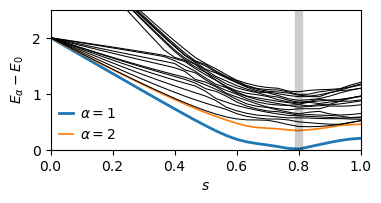

"ax = subplot(212)\naxvline(s_gap, ls = \"-\", c=\"k\", alpha=0.2, lw=6)\nplot(exact_times, abs.(overlap_01_z .- overlap_01_x), label = \"\$alpha = 1\$\", \"-C0\", lw=2.0)\nxlim(0.0, 1.0)\nax.set_yticks([0, 1.0])\n# ylim(0, 1)\nxlabel(\"\$s\$\")\n"

In [65]:
figure(figsize = (4, 4))

ax = subplot(211)
#axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
#plot(exact_times, lambda[1, :], lw = 2.0, alpha = 1)
for i in 1:20
	if i == 2 
		plot(exact_times, (lambda[i, :] .- lambda[1, :]), lw = 2.0, alpha = 1,label = L"\alpha = 1")
	elseif i == 3		
		plot(exact_times, (lambda[i, :] .- lambda[1, :]), lw = 1.25, alpha = 1,label = L"\alpha = 2")
	else
		plot(exact_times, (lambda[i, :] .- lambda[1, :]), "-k", lw=0.75, alpha = 1)
	end
	#plot(exact_times[2:end], bogo_spec[i, :] , "--k", lw = 1.5, alpha=0.5)
end
plot([], [], "-k", lw = 1)
axvline(s_gap, ls = "-", c="k", alpha=0.2, lw=6)
#plot([], [], label = "Bogoliubov", "--k", lw=1.5, alpha = 0.5)
xlim(0.0, 1.0)
ax.set_yticks(2 .* [0, 0.5, 1.0])
ylim(0, 2.5)
#ax.set_xticklabels([])
ylabel(L"E_\alpha - E_0")
xlabel("\$s\$")
legend(frameon = false, handlelength=1., handletextpad=0.5, borderaxespad=0.2)

"""
ax = subplot(212)
axvline(s_gap, ls = "-", c="k", alpha=0.2, lw=6)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x), label = "\$alpha = 1\$", "-C0", lw=2.0)
xlim(0.0, 1.0)
ax.set_yticks([0, 1.0])
# ylim(0, 1)
xlabel("\$s\$")
"""
#ylabel("\${|\langle \alpha|H_Z-H_X|0\rangle|}\$")

#legend(ncol=1, handlelength=1., handletextpad=0.5, borderaxespad=0.2, loc="upper left")

#display(gcf())

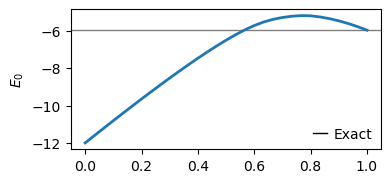

PyObject <matplotlib.legend.Legend object at 0x74207d135e50>

In [29]:
# plot ground state energy

figure(figsize = (4, 4))

ax = subplot(211)
axhline(gs_energy_o, ls = "-", c="k", alpha=0.5, lw=1)
plot(exact_times, lambda[1, :], lw = 2.0, alpha = 1)

plot([], [], "-k", lw = 1, label = "Exact")
#xlim(0.0, 1.0)
#ax.set_yticks(2 .* [0, 0.5, 1.0])
#ylim(0, 2)
#ax.set_xticklabels([])
ylabel("\$E_0\$")
legend(frameon = false, handlelength=1., handletextpad=0.5, borderaxespad=0.2)

#display(gcf())

#### Calculate the exact spectrum of the transformed instances

In [30]:
# Exact Energie spectrum

nev = 100
keep_EVs = 10

exact_times = range(0, 1, time_step)
eigeninfo = map(s -> (eigs(-hamiltonian(1 - s, s, mf_problem.local_fields, mf_problem.couplings), nev=nev, which=:LM, maxiter=10000)), exact_times)
lambda_s = [vals[1] for vals in eigeninfo]
lambda = sort(reduce(hcat, lambda_s), dims=1)


#all_eigvecs = zeros(length(exact_times), 2^(N-1), keep_EVs)
all_eigvecs = zeros(length(exact_times), 2^(N), keep_EVs)
for k in 1:length(exact_times)
    sorting_perm = sortperm(lambda_s[k])
    all_eigvecs[k, :, :] .= eigeninfo[k][2][:, sorting_perm[1:keep_EVs]]
end

# without fixing a spin
#all_eigvecs = zeros(length(exact_times), 2^(N-1), keep_EVs)
all_eigvecs = zeros(length(exact_times), 2^(N), keep_EVs)
for k in 1:length(exact_times)
    sorting_perm = sortperm(lambda_s[k])
    all_eigvecs[k, :, :] .= eigeninfo[k][2][:, sorting_perm[1:keep_EVs]]
end

println(lambda[1, :])

[-12.000000000000007, -11.619132456582854, -11.278737033649975, -10.982554890176809, -10.735082709196757, -10.542047960230972, -10.411385044265135, -10.354893721004355, -10.389632528415046, -10.532836213331244, -10.783698364314638, -11.119888819510267, -11.519046604149192, -11.966742770473536, -12.453732877217911, -13.00321805920216, -13.613547494579397, -14.250448304381624, -14.910366884590776, -15.590365436084184, -16.287963849198597, -17.001041311484162, -17.727770814287208, -18.466572105531004, -19.21607524882176, -19.975090748312642, -20.742584238904666, -21.51765474115328, -22.29951592199116, -23.087479977410062, -23.880943817852064]


In [32]:
# calculate adiabatic ratio

H_x = SpinFluctuations.hamiltonian(1, 0, mf_problem.local_fields, mf_problem.couplings)
H_z = SpinFluctuations.hamiltonian(0, 1, mf_problem.local_fields, mf_problem.couplings);

gs = [all_eigvecs[k, :, 1] for k in 1:length(exact_times)]
first_ex = [all_eigvecs[k, :, 2] for k in 1:length(exact_times)]
second_ex = [all_eigvecs[k, :, 3] for k in 1:length(exact_times)]

overlap_01_x = [first_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_01_z = [first_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)]

overlap_02_x = [second_ex[k]' * H_x * gs[k] for k in 1:length(exact_times)]
overlap_02_z = [second_ex[k]' * H_z * gs[k] for k in 1:length(exact_times)];

#println(abs.(overlap_01_z .- overlap_01_x))

gap = lambda[2, :] .- lambda[1, :];
mingap = minimum(gap)
#mingap |> println
gap_idx = findfirst(x -> x == mingap, gap)
s_gap = exact_times[gap_idx]
println("s_* for Gamma = 1:")

println(gap .* gap)
println(abs.(overlap_01_z .- overlap_01_x).\ gap.*gap)


s_gap |> println

s_* for Gamma = 1:
[3.9999999999998224, 3.1478407416407626, 2.3998285859452806, 1.7576130850953395, 1.22213944364105, 0.7938494891459709, 0.4723893844237845, 0.2546002121973139, 0.1294559793269232, 0.07205589306370222, 0.04791510040003309, 0.03236646183343998, 0.018489613767078424, 0.007310105173773906, 0.0008920233011966137, 0.0008771622171104306, 0.008433384201611193, 0.024298262663774925, 0.048773768926474774, 0.08170669359000059, 0.122489674008311, 0.17010038528273846, 0.2231816498780294, 0.28015477541725686, 0.3393519655596359, 0.3991504079668969, 0.4580902863301955, 0.5149617775233108, 0.5688522103848068, 0.6191528179985588, 0.6655323400007024]
[16.745241813366615, 7.589584874902109, 4.768418515643922, 2.863329897343479, 1.6137314646571523, 0.838094306889156, 0.3959044596690624, 0.1729003366868329, 0.07885252600332236, 0.051401787527206574, 0.05909908377088976, 0.09433425754223358, 0.15819413309615518, 0.26791287449211015, 0.052963500087454644, 0.041326610138756596, 2.20720061975

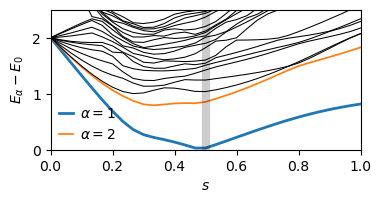

"ax = subplot(212)\naxvline(s_gap, ls = \"-\", c=\"k\", alpha=0.2, lw=6)\nplot(exact_times, abs.(overlap_01_z .- overlap_01_x), label = \"\$alpha = 1\$\", \"-C0\", lw=2.0)\nxlim(0.0, 1.0)\nax.set_yticks([0, 1.0])\n# ylim(0, 1)\nxlabel(\"\$s\$\")\n"

In [33]:
figure(figsize = (4, 4))

ax = subplot(211)
#axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
#plot(exact_times, lambda[1, :], lw = 2.0, alpha = 1)
for i in 1:20
	if i == 2 
		plot(exact_times, (lambda[i, :] .- lambda[1, :]), lw = 2.0, alpha = 1, label = L"\alpha = 1")
	elseif i == 3		
		plot(exact_times, (lambda[i, :] .- lambda[1, :]), lw = 1.25, alpha = 1, label = L"\alpha = 2")
	else
		plot(exact_times, (lambda[i, :] .- lambda[1, :]), "-k", lw=0.75, alpha = 1)
	end
	#plot(exact_times[2:end], bogo_spec[i, :] , "--k", lw = 1.5, alpha=0.5)
end
plot([], [], "-k", lw = 1)
axvline(s_gap, ls = "-", c="k", alpha=0.2, lw=6)
#plot([], [], label = "Bogoliubov", "--k", lw=1.5, alpha = 0.5)
xlim(0.0, 1.0)
ax.set_yticks(2 .* [0, 0.5, 1.0])
ylim(0, 2.5)
#ax.set_xticklabels([])
ylabel(L"E_\alpha - E_0")
xlabel("\$s\$")
legend(frameon = false, handlelength=1., handletextpad=0.5, borderaxespad=0.2)

"""
ax = subplot(212)
axvline(s_gap, ls = "-", c="k", alpha=0.2, lw=6)
plot(exact_times, abs.(overlap_01_z .- overlap_01_x), label = "\$alpha = 1\$", "-C0", lw=2.0)
xlim(0.0, 1.0)
ax.set_yticks([0, 1.0])
# ylim(0, 1)
xlabel("\$s\$")
"""
#ylabel("\${|\langle \alpha|H_Z-H_X|0\rangle|}\$")

#legend(ncol=1, handlelength=1., handletextpad=0.5, borderaxespad=0.2, loc="upper left")

#display(gcf())

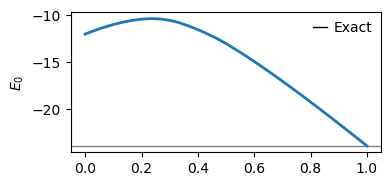

PyObject <matplotlib.legend.Legend object at 0x742081ff0ef0>

In [34]:
# plot ground state energy

figure(figsize = (4, 4))

ax = subplot(211)
axhline(gs_energy, ls = "-", c="k", alpha=0.5, lw=1)
plot(exact_times, lambda[1, :], lw = 2.0, alpha = 1)

plot([], [], "-k", lw = 1, label = "Exact")
#xlim(0.0, 1.0)
#ax.set_yticks(2 .* [0, 0.5, 1.0])
#ylim(0, 2)
#ax.set_xticklabels([])
ylabel("\$E_0\$")
legend(frameon = false, handlelength=1., handletextpad=0.5, borderaxespad=0.2)

#display(gcf())

### Mean field Approximation

#### Original instance:

In [58]:
# mean field evolution

T_final = 32768.
tol = 1e-6


schedule(t) = t / T_final
sol = evolve_mean_field(mf_problem_o.local_fields, mf_problem_o.couplings, T_final, schedule, rtol=1e2tol, atol=tol) 

# get mean-field solution
solution = S -> sign.([S[3, i] for i in 1:size(S)[2]])
mf_sol = solution(sol(T_final)) 

writable_data = zeros(length(sol.u), size(sol.u[1])...)
for i in 1:length(sol.u)
    writable_data[i, :, :] .= sol.u[i]
end

sol_t = sol.t
sol_u = writable_data


nx_vals = n_vals("x", sol_u)
ny_vals = n_vals("y", sol_u)
nz_vals = n_vals("z", sol_u);

Mean field solution bitstring of original instance

In [59]:
# get the bitstring solution of the mean field z components

bit = sol.u[end]
bitstring_original = bit[3,:]
bitstring_original

12-element Vector{Float64}:
  1.0000246089892992
  1.000004474521278
 -1.0000018137767008
  0.9999073103532243
  1.0000698620167399
 -1.0000054817305686
 -1.0000225730111865
 -1.000007559334991
  1.0000070680394042
  1.0000035094349322
 -1.0000124281333396
  1.0000224340337263

Calcualte the spin frustration degree

In [60]:
# sort the spins by their degree of frustration

npts = 2048
coarse_times = range(0, 1, npts + 1)

#all_most_frustrated_spins = Dict()
#all_most_undecided_spins = Dict()

# From area under magnetization
#nxy_coarse = zeros(N-1)
nxy_coarse = zeros(N)

nx_coarse = n_coarse(nx_vals, sol_t, coarse_times)
ny_coarse = n_coarse(ny_vals, sol_t, coarse_times)
nz_coarse = n_coarse(nz_vals, sol_t, coarse_times);

S_vals = [transpose(reduce(hcat, [nxy_coarse, nxy_coarse, nz_coarse[:, k]])) |> Matrix for k in 1:npts+1]

magnetizations = reduce(hcat, map(S -> magnetization(S, mf_problem_o.local_fields, mf_problem_o.couplings), S_vals));


# Get most frustrated spins from area under magnetization
areas = Dict()
dts = [(x[2] - x[1]) / T_final for x in zip(coarse_times[1:end-1], coarse_times[2:end])]

#for spin_idx in 1:N-1
for spin_idx in 1:N  
    areas[spin_idx] = sum(dts .* magnetizations[spin_idx, 2:end]) |> abs
end
all_most_frustrated_spins = [k for (k, v) in sort(areas |> collect, by=x->x[2])]

# From area under Edwards-Anderson order parameter
nzs = reduce(hcat, [sol_u[k, 3, :] for k in 1:size(sol_u)[1]])

# Get "most undecided spin" from area under z components
EA_param = Dict()
dts = [(x[2] - x[1]) / T_final for x in zip(sol_t[1:end-1], sol_t[2:end])]

#for spin_idx in 1:N-1
for spin_idx in 1:N 
    EA_param[spin_idx] = sum(dts .* nzs[spin_idx, 2:end] .^ 2) |> abs
end
all_most_undecided_spins = [k for (k, v) in sort(EA_param |> collect, by=x->x[2])]    

top_idxs = [k for (k, v) in sort(areas |> collect, by = x -> x[2])]
#top_idxs = [k for (k, v) in sort(EA_param |> collect, by = x -> x[2])]
top_idx = top_idxs[1]

regular_trajectories = filter!(x -> x != top_idx, collect(1:N));

println(all_most_frustrated_spins)
println(top_idxs)

#perm_order = all_most_frustrated_spins
perm_order = top_idxs

[11, 8, 2, 6, 9, 7, 12, 10, 3, 1, 5, 4]
[11, 8, 2, 6, 9, 7, 12, 10, 3, 1, 5, 4]


12-element Vector{Int64}:
 11
  8
  2
  6
  9
  7
 12
 10
  3
  1
  5
  4

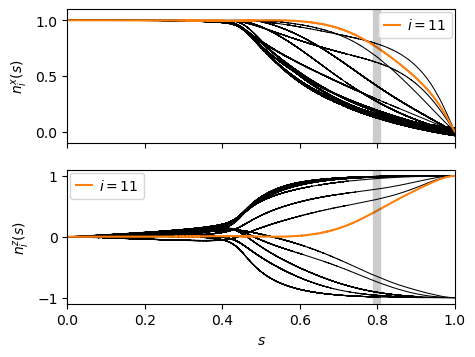

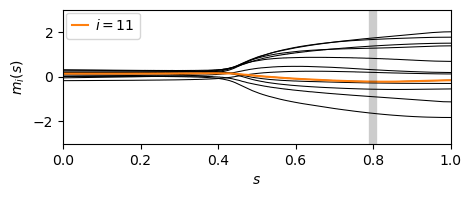

PyObject <matplotlib.legend.Legend object at 0x742081fbf680>

In [61]:
figure(figsize = (5, 8))

c1 = "-C1"
c2 = "-C0"

ax = subplot(411)
#axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in 1:N#regular_trajectories
	plot(sol_t ./ sol_t[end], nx_vals[spin_nr, :], "-k", lw=0.75)
end
# plot(sol_t ./ sol_t[end], nx_vals[top_idxs[2], :], c2, lw=1, label = @sprintf("$i=%i$", top_idxs[2]))
plot(sol_t ./ sol_t[end], nx_vals[top_idx, :], c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))
axvline(s_gap_old, ls = "-", c="k", alpha=0.2, lw=6)
xlim(0, 1)
ax.set_xticklabels([])
#ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ylim(-0.1, 1.1)
ylabel("\$n_i^x(s)\$")
#xticks(0:0.05:1.0)
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)
#display(gcf())

#figure(figsize = (4, 3))
ax = subplot(412)
#axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in 1:N#regular_trajectories
	plot(sol_t ./ T_final, nz_vals[spin_nr, :], "-k", lw=0.75)
end
# plot(sol_t ./ T_final, nz_vals[top_idxs[2], :], c2, lw=1)
plot(sol_t ./ T_final, nz_vals[top_idx, :].^2, c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))
axvline(s_gap_old, ls = "-", c="k", alpha=0.2, lw=6)
xlim(0, 1)
#xticks(0:0.05:1.0)
#ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ylim(-1.1, 1.1)
#ax.set_xticklabels([])
xlabel("\$s\$")
ylabel("\$n_i^z(s)\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)
#display(gcf())

figure(figsize = (5, 8))
ax = subplot(414)
#axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in 1:N#regular_trajectories
	plot(coarse_times, magnetizations[spin_nr, :], "-k", lw=0.75)
end
# plot(coarse_times, magnetizations[top_idxs[2], :], c2, lw=1, label = @sprintf("$i=%i$", top_idxs[2]))
plot(coarse_times, magnetizations[top_idx, :], c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))
axvline(s_gap_old, ls = "-", c="k", alpha=0.2, lw=6)
xlim(0.0, 1)
ylim(-3, 3)
xlabel("\$s\$")
ylabel("\$m_i(s)\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)
#display(gcf())

#### Transformed instance:

In [67]:
# mean field evolution

T_final = 32768.
tol = 1e-6


schedule(t) = t / T_final
sol = evolve_mean_field(mf_problem.local_fields, mf_problem.couplings, T_final, schedule, rtol=1e2tol, atol=tol) 

# get mean-field solution
solution = S -> sign.([S[3, i] for i in 1:size(S)[2]])
mf_sol = solution(sol(T_final)) 

writable_data = zeros(length(sol.u), size(sol.u[1])...)
for i in 1:length(sol.u)
    writable_data[i, :, :] .= sol.u[i]
end

sol_t = sol.t
sol_u = writable_data


nx_vals = n_vals("x", sol_u)
ny_vals = n_vals("y", sol_u)
nz_vals = n_vals("z", sol_u);

Mean field solution bitstring of transformed instance

In [53]:
# get the bitstring solution of the mean field z components

bit_trans = sol.u[end]
bitstring_trans = bit_trans[3,:]
bitstring_trans

12-element Vector{Float64}:
 -1.0000086923836369
  1.0000064008829361
 -1.0000048172167075
  1.0000039667842977
 -1.0000031018251425
  1.0000172533533016
 -1.0000160403383525
  1.0000028297002808
  1.000022409575742
 -0.999984429805875
  1.0001348676523674
  0.999878525981865

Caculate the spin frustration degree

In [54]:
# sort the spins by their degree of frustration

npts = 2048
coarse_times = range(0, 1, npts + 1)

#all_most_frustrated_spins = Dict()
#all_most_undecided_spins = Dict()

# From area under magnetization
#nxy_coarse = zeros(N-1)
nxy_coarse = zeros(N)

nx_coarse = n_coarse(nx_vals, sol_t, coarse_times)
ny_coarse = n_coarse(ny_vals, sol_t, coarse_times)
nz_coarse = n_coarse(nz_vals, sol_t, coarse_times);

S_vals = [transpose(reduce(hcat, [nxy_coarse, nxy_coarse, nz_coarse[:, k]])) |> Matrix for k in 1:npts+1]

magnetizations = reduce(hcat, map(S -> magnetization(S, mf_problem.local_fields, mf_problem.couplings), S_vals));


# Get most frustrated spins from area under magnetization
areas = Dict()
dts = [(x[2] - x[1]) / T_final for x in zip(coarse_times[1:end-1], coarse_times[2:end])]

#for spin_idx in 1:N-1
for spin_idx in 1:N  
    areas[spin_idx] = sum(dts .* magnetizations[spin_idx, 2:end]) |> abs
end
all_most_frustrated_spins = [k for (k, v) in sort(areas |> collect, by=x->x[2])]

# From area under Edwards-Anderson order parameter
nzs = reduce(hcat, [sol_u[k, 3, :] for k in 1:size(sol_u)[1]])

# Get "most undecided spin" from area under z components
EA_param = Dict()
dts = [(x[2] - x[1]) / T_final for x in zip(sol_t[1:end-1], sol_t[2:end])]

#for spin_idx in 1:N-1
for spin_idx in 1:N 
    EA_param[spin_idx] = sum(dts .* nzs[spin_idx, 2:end] .^ 2) |> abs
end
all_most_undecided_spins = [k for (k, v) in sort(EA_param |> collect, by=x->x[2])]    

top_idxs = [k for (k, v) in sort(areas |> collect, by = x -> x[2])]
#top_idxs = [k for (k, v) in sort(EA_param |> collect, by = x -> x[2])]
top_idx = top_idxs[1]

regular_trajectories = filter!(x -> x != top_idx, collect(1:N));

println(all_most_frustrated_spins)
println(top_idxs)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


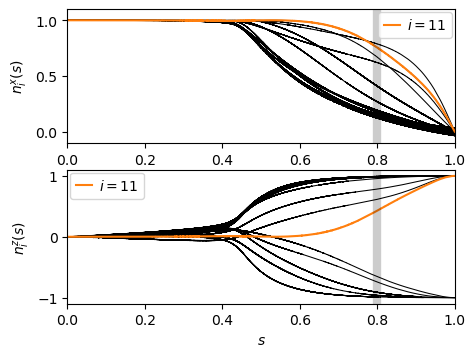

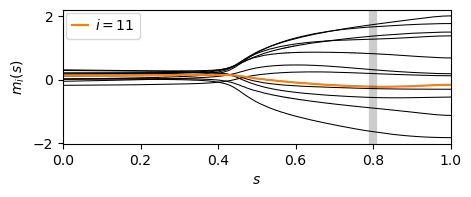

PyObject <matplotlib.legend.Legend object at 0x74207c7eef90>

In [66]:
figure(figsize = (5, 8))

c1 = "-C1"
c2 = "-C0"

ax = subplot(411)
#axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in 1:N-1 #regular_trajectories
	plot(sol_t ./ sol_t[end], nx_vals[spin_nr, :], "-k", lw=0.75)
end
# plot(sol_t ./ sol_t[end], nx_vals[top_idxs[2], :], c2, lw=1, label = @sprintf("$i=%i$", top_idxs[2]))
plot(sol_t ./ sol_t[end], nx_vals[top_idx, :], c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))
axvline(s_gap, ls = "-", c="k", alpha=0.2, lw=6)
xlim(0, 1)
ax.set_xticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
#ax.set_yticks([-1.0, -0.5, 0.0, 0.5, 1.0])
ylim(-0.1, 1.1)
ylabel("\$n_i^x(s)\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)
#display(gcf())

#figure(figsize = (4, 3))
ax = subplot(412)
#axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in 1:N#regular_trajectories
	plot(sol_t ./ T_final, nz_vals[spin_nr, :], "-k", lw=0.75)
end
# plot(sol_t ./ T_final, nz_vals[top_idxs[2], :], c2, lw=1)
plot(sol_t ./ T_final, nz_vals[top_idx, :].^2, c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))
axvline(s_gap, ls = "-", c="k", alpha=0.2, lw=6)
xlim(0, 1)
ylim(-1.1, 1.1)
#ax.set_xticklabels([])
ylabel("\$n_i^z(s)\$")
xlabel("\$s\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)
#display(gcf())

figure(figsize = (5, 8))
ax = subplot(414)
#axvline(gaploc, ls = "-", c="k", alpha=0.2, lw=6)
for spin_nr in 1:N#regular_trajectories
	plot(coarse_times, magnetizations[spin_nr, :], "-k", lw=0.75)
end
# plot(coarse_times, magnetizations[top_idxs[2], :], c2, lw=1, label = @sprintf("$i=%i$", top_idxs[2]))
plot(coarse_times, magnetizations[top_idx, :], c1, lw=1.5, label = @sprintf("\$i=%i\$", top_idx))
axvline(s_gap, ls = "-", c="k", alpha=0.2, lw=6)
xlim(0.0, 1)
#ylim(-6, 6)
xlabel("\$s\$")
ylabel("\$m_i(s)\$")
legend(handlelength=1.2, handletextpad=0.5, borderaxespad=0.2)
#display(gcf())

#### Brutforce way to get the exact solution bitstring of the optimazation problem

In [22]:
function energies_and_bitstrings_qaoa(annealing_problem)
    L = annealing_problem.num_qubits
    h = annealing_problem.local_fields
    J = annealing_problem.couplings
    
    bit_string_df = DataFrame( bit_string = [], energy = Float64[]);
    
    bitstrings = [string(i, base=2, pad=L) |> reverse for i in 0:(2^L - 1)]
    bitvals = [parse.(Int, [bitstring[j] for j in 1:L]) for bitstring in bitstrings]
    spins = [1 .- 2s for s in bitvals]
    
    for spin in spins
        energy = sum([-h[l] * spin[l] for l in 1:L]) + sum([-J[i, j] * spin[i] * spin[j] for i in 1:L for j in (i+1):L])
        push!(bit_string_df,[ spin, energy])
    end
    
    return bit_string_df
end

exact_solution_bitstring = energies_and_bitstrings_qaoa(mf_problem)

sorted_df = sort(exact_solution_bitstring, :energy)

lowest_energy_row = sorted_df[1, :]

println(lowest_energy_row)
exact_bitstring = lowest_energy_row[1]

DataFrameRow
 Row │ bit_string                         energy   
     │ Any                                Float64  
─────┼─────────────────────────────────────────────
   1 │ [1, -1, 1, -1, 1, -1, 1, -1, -1,…  -23.8809


12-element Vector{Int64}:
  1
 -1
  1
 -1
  1
 -1
  1
 -1
 -1
  1
 -1
 -1

#### Compare the solution bitstring before and after transformation

In [23]:
println("Permutation order:", perm_order)
perm_order = [6, 11, 8, 1, 9, 2, 10, 3, 7, 12, 4, 5]
println("bitstring before transformation: ", round.(Int, bitstring_original))
println("bitstring after transformation:  ", round.(Int, bitstring_trans))

bitstring_back = zeros(size(bitstring_trans))

# permute the rows and columns of J_mat 
for i in 1:length(perm_order)
    bitstring_back[perm_order[i]] = bitstring_trans[i]
end

println("bitstring after permuting back:  ", round.(Int, bitstring_back))
println("exact bitstring solution:        ", exact_bitstring)

Permutation order:

[11, 8, 2, 6, 9, 7, 12, 10, 3, 1, 5, 4]
bitstring before transformation: [1, 1, -1, 1, 1, -1, -1, -1, 1, 1, -1, 1]
bitstring after transformation:  [-1, 1, -1, 1, -1, 1, -1, 1, 1, -1, 1, 1]
bitstring after permuting back:  [1, 1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1]
exact bitstring solution:        [1, -1, 1, -1, 1, -1, 1, -1, -1, 1, -1, -1]
